# 자체적으로 관련 내용 GPT 구현

## acceptance-rejection method

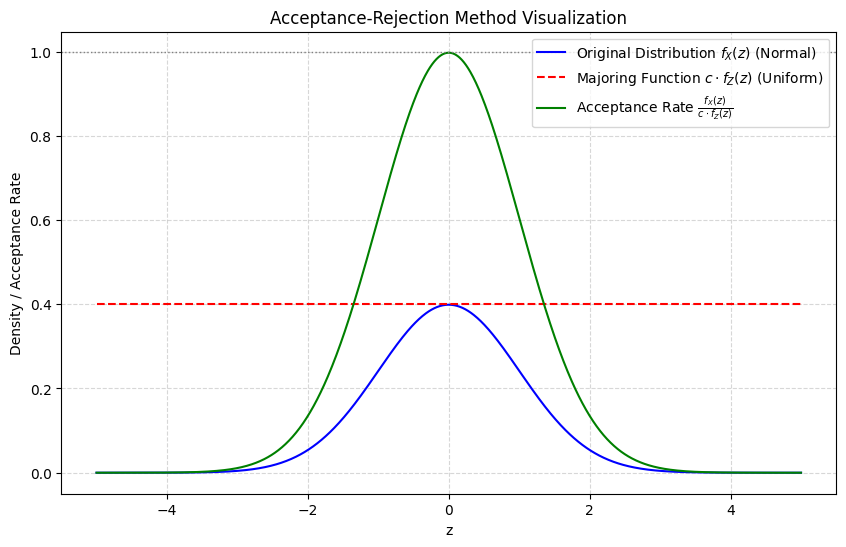

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform

# Define the range for z
z = np.linspace(-5, 5, 1000)

# 1. Original Distribution f_X (Standard Normal)
f_X = norm.pdf(z, loc=0, scale=1)  # Mean=0, Std Dev=1

# 2. Majoring Function c * f_Z (Uniform Distribution)
f_Z = uniform.pdf(z, loc=-5, scale=10)  # Uniform over [-5, 5]
c = 4
majoring_function = c * f_Z  # Constant value of 0.4

# 3. Acceptance Rate f_X(z) / (c * f_Z(z))
acceptance_rate = f_X / majoring_function  # Should be <= 1

# Plotting
plt.figure(figsize=(10, 6))

# Plot f_X(z)
plt.plot(z, f_X, label=r'Original Distribution $f_X(z)$ (Normal)', color='blue')

# Plot c * f_Z(z)
plt.plot(z, majoring_function, label=r'Majoring Function $c \cdot f_Z(z)$ (Uniform)', color='red', linestyle='--')

# Plot Acceptance Rate
plt.plot(z, acceptance_rate, label=r'Acceptance Rate $\frac{f_X(z)}{c \cdot f_Z(z)}$', color='green')

# Add horizontal line at acceptance rate = 1
plt.axhline(y=1, color='gray', linestyle=':', linewidth=1)

# Labels and Title
plt.xlabel('z')
plt.ylabel('Density / Acceptance Rate')
plt.title('Acceptance-Rejection Method Visualization')

# Legend
plt.legend()

# Grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Show Plot
plt.show()


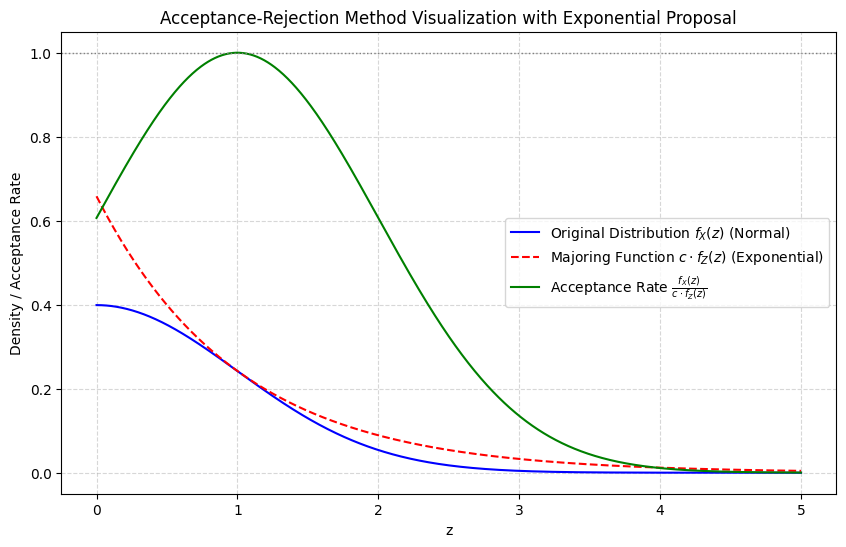

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

# Parameters
lambda_param = 1  # Rate parameter for Exponential distribution
c = 0.658         # Majoring constant calculated to satisfy c * f_Z(z) >= f_X(z) for all z >=0

# Define the range for z (0 to 5 for Exponential)
z = np.linspace(0, 5, 1000)

# 1. Original Distribution f_X (Standard Normal)
f_X = norm.pdf(z, loc=0, scale=1)  # Mean=0, Std Dev=1

# 2. Proposal Distribution f_Z (Exponential)
f_Z = expon.pdf(z, scale=1/lambda_param)  # Exponential with lambda=1

# Majoring Function c * f_Z(z)
majoring_function = c * f_Z  # 0.658 * e^{-z}

# 3. Acceptance Rate f_X(z) / (c * f_Z(z))
acceptance_rate = f_X / majoring_function  # Should be <=1

# Plotting
plt.figure(figsize=(10, 6))

# Plot f_X(z)
plt.plot(z, f_X, label=r'Original Distribution $f_X(z)$ (Normal)', color='blue')

# Plot c * f_Z(z)
plt.plot(z, majoring_function, label=r'Majoring Function $c \cdot f_Z(z)$ (Exponential)', color='red', linestyle='--')

# Plot Acceptance Rate
plt.plot(z, acceptance_rate, label=r'Acceptance Rate $\frac{f_X(z)}{c \cdot f_Z(z)}$', color='green')

# Add horizontal line at acceptance rate = 1
plt.axhline(y=1, color='gray', linestyle=':', linewidth=1)

# Labels and Title
plt.xlabel('z')
plt.ylabel('Density / Acceptance Rate')
plt.title('Acceptance-Rejection Method Visualization with Exponential Proposal')

# Legend
plt.legend()

# Grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Show Plot
plt.show()


Brownian Bridge

In [4]:
import numpy as np
import time

def ki_digital_bb(s0, maturity, ki_barrier, barrier, gain_coupon, loss_coupon, fulldummy, rfr, div, vol, nSim):
    """
    Pricing a barrier option using the Brownian Bridge method to enhance efficiency.
    
    Parameters:
    - s0: Initial asset price
    - maturity: Time to maturity (in years)
    - ki_barrier: Lower barrier (e.g., 0.7 * s0)
    - barrier: Upper barrier (e.g., 0.8 * s0)
    - gain_coupon: Payoff if S_T >= barrier
    - loss_coupon: Payoff if S_T < barrier and min(S(t)) < ki_barrier
    - fulldummy: Payoff if S_T < barrier and min(S(t)) >= ki_barrier
    - rfr: Risk-free rate
    - div: Dividend yield
    - vol: Volatility of the asset
    - nSim: Number of Monte Carlo simulations
    
    Returns:
    - val: Estimated option price
    - cal_time: Calculation time
    - barrier_prob: Probability that terminal price >= barrier
    """
    start_time = time.time()
    days = 250  # Number of trading days in a year
    ntime = int(days * maturity)  # Total number of time steps
    time_grid = np.linspace(0, maturity, ntime + 1)  # Time grid from 0 to T
    drift = rfr - div - 0.5 * vol ** 2  # Drift component of GBM
    dt = time_grid[1] - time_grid[0]  # Time step size
    
    sum_payoff = 0  # Initialize sum of payoffs
    barrier_prob_cnt = 0  # Count of simulations where S_T >= barrier
    
    # Step 1: Simulate all terminal asset prices at once
    Z_terminal = np.random.normal(size=nSim)  # Generate all terminal Z's
    s_mat = s0 * np.exp(drift * maturity + vol * np.sqrt(maturity) * Z_terminal)  # Terminal prices
    
    # Step 2: Iterate over each simulation
    for i in range(nSim):
        S_T = s_mat[i]  # Terminal price for simulation i
        ratio_T = S_T / s0  # S_T / S0
        
        if ratio_T >= barrier:
            # Case 1: Terminal price exceeds barrier
            payoff = gain_coupon
            barrier_prob_cnt += 1  # Increment barrier exceedance count
        else:
            # Case 2: Terminal price below barrier, need to check for lower barrier breach
            
            # Step 2a: Calculate standardized terminal log-price (Z_T)
            Z_T = (np.log(S_T / s0) - drift * maturity) / vol
            
            # Step 2b: Simulate intermediate Brownian motion (W(t))
            Z_intermediate = np.random.normal(size=ntime)  # Intermediate random variables
            W_t = np.cumsum(Z_intermediate * np.sqrt(dt))  # Simulated Brownian motion path
            
            # Step 2c: Construct the Brownian Bridge
            t_over_T = time_grid / maturity  # t / T
            # Ensure W_t has the same length as time_grid by padding with zero at the start
            W_t_full = np.zeros(ntime + 1)
            W_t_full[1:] = W_t  # Shift W_t by one to align with time_grid
            B_t = Z_T * t_over_T + W_t_full - t_over_T * W_t_full[-1]
            
            # Step 2d: Generate the asset price path using the bridge
            S_t = s0 * np.exp(drift * time_grid + vol * B_t)
            
            # Step 2e: Determine the payoff based on barrier conditions
            min_S_t = np.min(S_t)  # Minimum asset price during the path
            ratio_min = min_S_t / s0  # min(S(t)) / S0
            
            if ratio_min >= ki_barrier:
                # No breach of lower barrier
                payoff = fulldummy
            else:
                # Breach of lower barrier
                payoff = loss_coupon
        
        # Accumulate the payoff
        sum_payoff += payoff
    
    # Step 3: Calculate the discounted average payoff
    avg_payoff = sum_payoff / nSim
    val = round(avg_payoff * np.exp(-rfr * maturity), 3)  # Discounted to present value
    
    # Step 4: Calculate calculation time and barrier exceedance probability
    cal_time = round(time.time() - start_time, 3)
    barrier_prob = round(barrier_prob_cnt / nSim, 3)
    
    return val, cal_time, barrier_prob

# Example Usage:
if __name__ == '__main__':
    # Define parameters
    s0 = 1
    maturity = 1
    ki_barrier = 0.7
    barrier = 0.8
    gain_coupon = 0.10
    loss_coupon = -0.10
    fulldummy = 0.10
    rfr = 0.02
    div = 0
    vol = 0.3
    nSim = 10000
    
    # Run simulations
    val, cal_time, barrier_prob = ki_digital_bb(
        s0, maturity, ki_barrier, barrier,
        gain_coupon, loss_coupon, fulldummy,
        rfr, div, vol, nSim
    )
    
    print('Option Value (BB): {}, Elapsed Time: {} sec, Barrier Exceedance Probability: {}'.format(val, cal_time, barrier_prob))


Option Value (BB): 0.059, Elapsed Time: 0.081 sec, Barrier Exceedance Probability: 0.749


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time

def visualize_brownian_bridge_simulation(s0, maturity, ki_barrier, barrier, drift, vol, dt):
    """
    Simulates a single barrier option path using the Brownian Bridge method and visualizes each step.
    """
    # Initialize time grid
    days = int(250 * maturity)
    ntime = days
    time_grid = np.linspace(0, maturity, ntime + 1)
    
    # Step 1: Simulate Terminal Asset Price
    Z_terminal = np.random.normal()
    S_T = s0 * np.exp(drift * maturity + vol * np.sqrt(maturity) * Z_terminal)
    ratio_T = S_T / s0
    print(f"Z_terminal: {Z_terminal:.4f}")
    print(f"Terminal Asset Price (S_T): {S_T:.4f}")
    print(f"Ratio_T: {ratio_T:.4f}")
    
    if ratio_T >= barrier:
        payoff = 0.10  # gain_coupon
        print(f"S_T >= Barrier ({barrier}) --> Payoff: {payoff}")
        
        # Plotting the simple path
        plt.figure(figsize=(12, 6))
        plt.plot([0, maturity], [s0, S_T], marker='o', label='Asset Price Path (S(t))', color='blue')
        plt.axhline(y=barrier, color='green', linestyle='--', label='Barrier (80%)')
        plt.axhline(y=ki_barrier, color='red', linestyle='--', label='Lower Barrier (70%)')
        plt.scatter([0, maturity], [s0, S_T], color='black', zorder=5, label='Start and End Points')
        plt.title('Asset Price Path Above Barrier')
        plt.xlabel('Time (Years)')
        plt.ylabel('Asset Price')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"S_T < Barrier ({barrier}) --> Proceeding to Brownian Bridge")
        
        # Step 2a: Calculate Z_T
        Z_T = (np.log(S_T / s0) - drift * maturity) / vol
        print(f"Z_T: {Z_T:.4f}")
        
        # Step 2b: Simulate Intermediate Brownian Motion W(t)
        Z_intermediate = np.random.normal(size=ntime)
        W_t = np.cumsum(Z_intermediate * np.sqrt(dt))
        
        # Step 2c: Construct the Brownian Bridge B(t)
        t_over_T = time_grid / maturity
        W_t_full = np.zeros(ntime + 1)
        W_t_full[1:] = W_t  # Shift W_t to align with time_grid
        B_t = Z_T * t_over_T + W_t_full - t_over_T * W_t_full[-1]
        
        # Step 2d: Generate Asset Price Path S(t)
        S_t = s0 * np.exp(drift * time_grid + vol * B_t)
        
        # Step 2e: Determine Payoff
        min_S_t = np.min(S_t)
        ratio_min = min_S_t / s0
        print(f"Minimum Asset Price During Path: {min_S_t:.4f}")
        print(f"Ratio_Min: {ratio_min:.4f}")
        
        if ratio_min >= ki_barrier:
            payoff = 0.10  # fulldummy
            print(f"min(S(t)) >= ki_barrier ({ki_barrier}) --> Payoff: {payoff}")
        else:
            payoff = -0.10  # loss_coupon
            print(f"min(S(t)) < ki_barrier ({ki_barrier}) --> Payoff: {payoff}")
        
        # Plotting the Brownian Bridge Asset Price Path
        plt.figure(figsize=(12, 6))
        plt.plot(time_grid, S_t, label='Asset Price Path (S(t))', color='blue')
        plt.axhline(y=barrier, color='green', linestyle='--', label='Barrier (80%)')
        plt.axhline(y=ki_barrier, color='red', linestyle='--', label='Lower Barrier (70%)')
        plt.scatter([0, maturity], [s0, S_T], color='black', zorder=5, label='Start and End Points')
        plt.title('Asset Price Path Using Brownian Bridge')
        plt.xlabel('Time (Years)')
        plt.ylabel('Asset Price')
        plt.legend()
        plt.grid(True)
        plt.show()


Z_terminal: 0.7488
Terminal Asset Price (S_T): 1.2210
Ratio_T: 1.2210
S_T >= Barrier (0.8) --> Payoff: 0.1


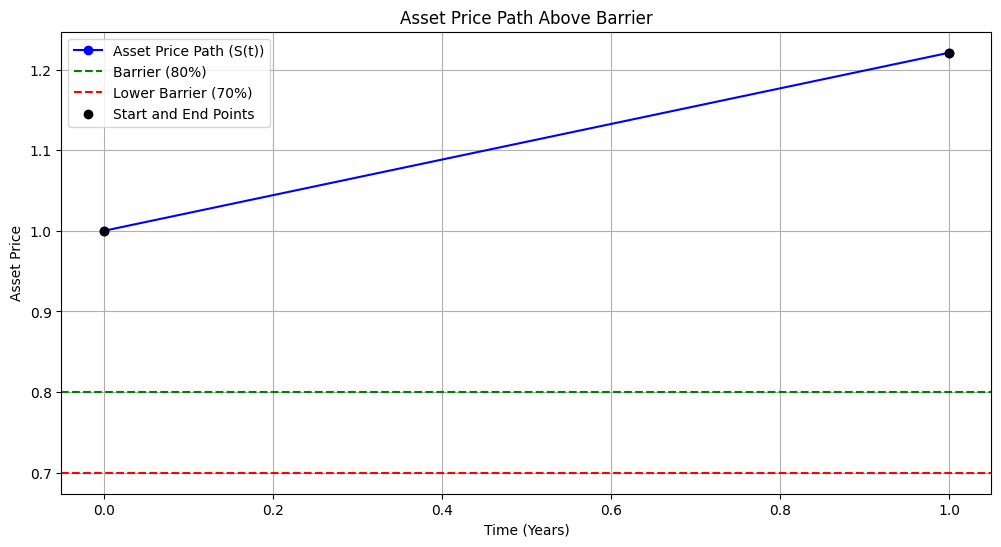

In [6]:
# Define parameters
s0 = 1
maturity = 1
ki_barrier = 0.7
barrier = 0.8
drift = 0.02 - 0 - 0.5 * 0.3 ** 2  # rfr - div - 0.5 * sigma^2
vol = 0.3
dt = 1 / 250  # Assuming 250 trading days

# Visualize a single simulation
visualize_brownian_bridge_simulation(s0, maturity, ki_barrier, barrier, drift, vol, dt)


Z_terminal: 0.3176
Terminal Asset Price (S_T): 1.0728
Ratio_T: 1.0728
S_T >= Barrier (0.8) --> Payoff: 0.1


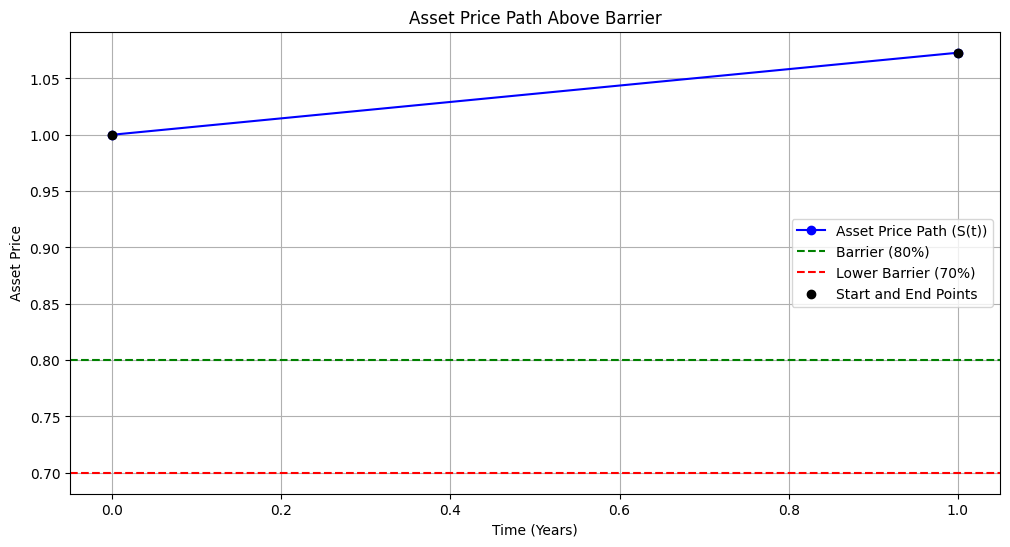

--------------------------------------------------------------------------------
Z_terminal: -1.7536
Terminal Asset Price (S_T): 0.5763
Ratio_T: 0.5763
S_T < Barrier (0.8) --> Proceeding to Brownian Bridge
Z_T: -1.7536
Minimum Asset Price During Path: 0.5763
Ratio_Min: 0.5763
min(S(t)) < ki_barrier (0.7) --> Payoff: -0.1


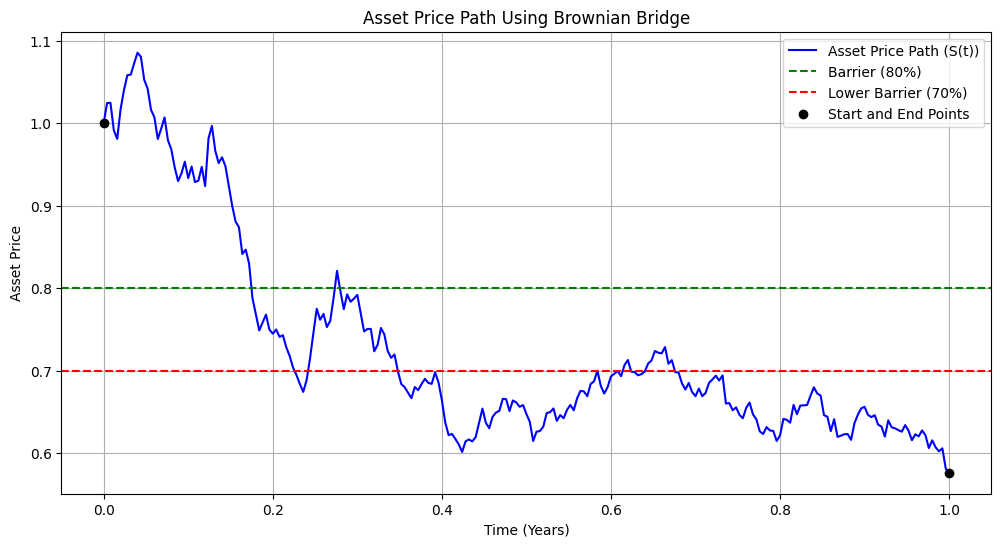

--------------------------------------------------------------------------------
Z_terminal: -0.3759
Terminal Asset Price (S_T): 0.8713
Ratio_T: 0.8713
S_T >= Barrier (0.8) --> Payoff: 0.1


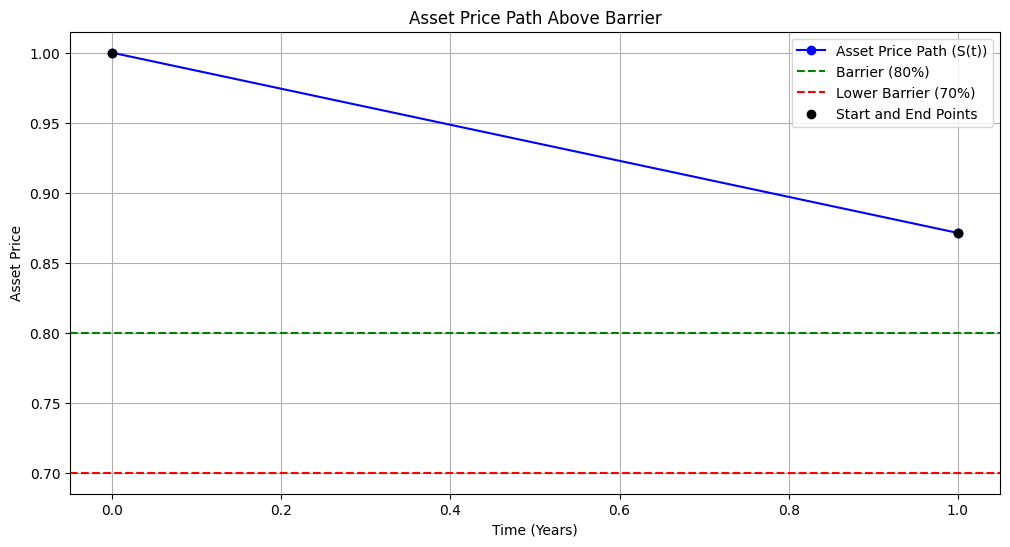

--------------------------------------------------------------------------------


In [7]:
def run_multiple_simulations(nSim):
    for _ in range(nSim):
        visualize_brownian_bridge_simulation(s0, maturity, ki_barrier, barrier, drift, vol, dt)
        print("-" * 80)

# Run 3 simulations
run_multiple_simulations(3)


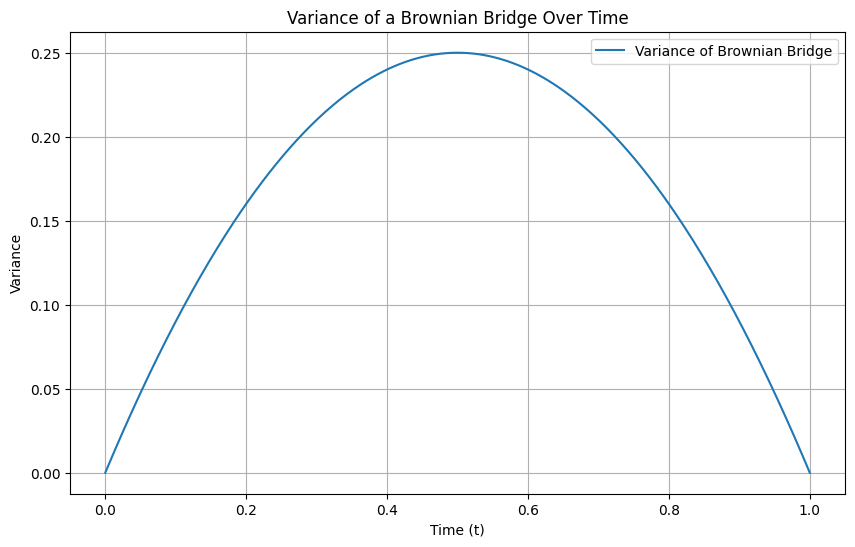

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T = 1  # Total time
time_grid = np.linspace(0, T, 500)  # Time points
variance = (time_grid * (T - time_grid)) / T  # Variance at each time t

# Plotting the variance
plt.figure(figsize=(10, 6))
plt.plot(time_grid, variance, label='Variance of Brownian Bridge')
plt.title('Variance of a Brownian Bridge Over Time')
plt.xlabel('Time (t)')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)
plt.show()
